# Initialize Notebook

In [1]:
%%capture
!pip install -U imbalanced-learn
!pip install -U graphviz
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pylab import rcParams
import seaborn as sns

project_id = ''  ###BQ Dataset Project ID
dataset = ''  
dataset_id = project_id + '.' + dataset

# BigQuery Magic

In [2]:
%%capture
%%bigquery training_data
select * from dataset_id.training_data

In [3]:
%%capture
%%bigquery card_transactions
select * from dataset_id.card_transactions;

In [4]:
card_transactions.head()

,cc_number,trans_id,trans_time,epoch_time,category,merchant,merchant_lat,merchant_lon,amount,is_fraud,trans_date
0,371821639871755,d8cc3431440fded0b04038e4c42a89da,15:11:30,1491405090,home,"Moore, Williamson and Emmerich",40.712096,-105.912224,83.02,False,2018-04-05
1,3529706446090100,45ddc9a40bcebd82f7b2c846400aad6f,10:07:21,1491386841,home,Ernser-Feest,39.029924,-104.077651,43.21,False,2018-04-05
2,5380965134941387,b39ba24e912774b450c37b5bf25bce2f,09:43:35,1491385415,home,Pollich LLC,39.756947,-104.128396,125.94,False,2018-04-05
3,2296809357680324,207f35b831538665a4f20a5384dad206,16:22:33,1491409353,travel,Lemke and Sons,39.576719,-104.216055,7.13,False,2018-04-05
4,2720889479416357,8f830a344640d8a817169fbf8c92679c,21:57:56,1491429476,travel,Gislason Group,40.051479,-104.108119,5.78,False,2018-04-05


Total # of Fraudulent Tx: 3245
Total # of Non-Fraudulent Tx: 1334154
Proportion of Fraudulent Tx: 0.243%


<AxesSubplot:>

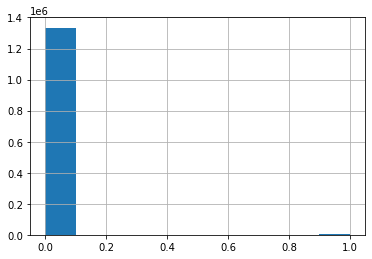

In [5]:
# Check Class Imbalance
fraud = len(training_data[training_data['is_fraud'] == True])
nonfraud = len(training_data[training_data['is_fraud'] != True])
print('Total # of Fraudulent Tx: {:.0f}'.format(fraud))
print('Total # of Non-Fraudulent Tx: {:.0f}'.format(nonfraud))
print('Proportion of Fraudulent Tx: {:.3f}%'.format(fraud/nonfraud*100))
training_data.is_fraud.astype(float).hist()

# Train a Baseline Model

![tree](https://github.com/yantkgcp/MLOps/blob/main/gbtree.png?raw=true)

In [6]:
# Baseline - Step 1: Train a baseline model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

X = training_data.set_index('trans_id')
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,-3:], X.is_fraud, random_state = 0)

#lr_clf = LogisticRegression().fit(X_train, y_train)
lr_clf = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)
#lr_clf = RandomForestClassifier(random_state = 0).fit(X_train, y_train)

y_test.astype(str).value_counts(), y_train.astype(str).value_counts()

(False    333547
 True        803
 Name: is_fraud, dtype: int64,
 False    1000607
 True        2442
 Name: is_fraud, dtype: int64)

Accuracy of baseline classifier on training set: 0.997566420
Accuracy of baseline classifier on test set: 0.997598325
Accuracy: 0.99760
Precision: 0.00000
Recall: 0.00000
F1: 0.00000
Confusion Matrix (Baseline Classifier)
 [[333547      0]
 [   803      0]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.00      0.00      0.00       803

    accuracy                           1.00    334350
   macro avg       0.50      0.50      0.50    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (Baseline_model)')

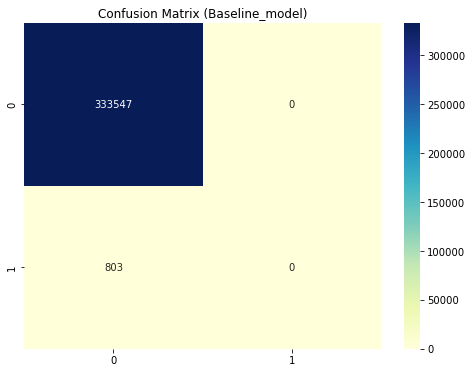

In [7]:
# Baseline - Step 2: Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


print('Accuracy of baseline classifier on training set: {:.9f}'
     .format(lr_clf.score(X_train, y_train)))
print('Accuracy of baseline classifier on test set: {:.9f}'
     .format(lr_clf.score(X_test, y_test)))

lr_predicted = lr_clf.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, lr_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, lr_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, lr_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, lr_predicted)))

print('Confusion Matrix (Baseline Classifier)\n', confusion)

print(classification_report(y_test, lr_predicted, target_names=['not Fraud', 'Fraud']))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap='YlGnBu', annot = True, fmt='d')
ax.set_title('Confusion Matrix (Baseline_model)')

### Accuracy 99.76%

# Feature Exploration

### Transaction Amount - Log transformation

In [8]:
training_data.head()

,trans_id,is_fraud,card_transactions_amount,card_transactions_transaction_distance,card_transactions_transaction_hour_of_day
0,5df2e4e157360e161dec3d0efcc07113,True,280.52,91969.612014,0
1,56a4aa3f26687f98625fb811aa27c1c1,True,316.06,118693.486710,0
2,42b451600d91afd85d680581394a9de4,True,1006.36,41594.869210,0
3,13cd837b85bb9f779c3265a72d4315e2,True,271.33,56662.386364,0
4,579b3a883b4030d91475428af9407c56,True,904.47,48332.349503,0


In [9]:
card_transactions.head()

,cc_number,trans_id,trans_time,epoch_time,category,merchant,merchant_lat,merchant_lon,amount,is_fraud,trans_date
0,371821639871755,d8cc3431440fded0b04038e4c42a89da,15:11:30,1491405090,home,"Moore, Williamson and Emmerich",40.712096,-105.912224,83.02,False,2018-04-05
1,3529706446090100,45ddc9a40bcebd82f7b2c846400aad6f,10:07:21,1491386841,home,Ernser-Feest,39.029924,-104.077651,43.21,False,2018-04-05
2,5380965134941387,b39ba24e912774b450c37b5bf25bce2f,09:43:35,1491385415,home,Pollich LLC,39.756947,-104.128396,125.94,False,2018-04-05
3,2296809357680324,207f35b831538665a4f20a5384dad206,16:22:33,1491409353,travel,Lemke and Sons,39.576719,-104.216055,7.13,False,2018-04-05
4,2720889479416357,8f830a344640d8a817169fbf8c92679c,21:57:56,1491429476,travel,Gislason Group,40.051479,-104.108119,5.78,False,2018-04-05


<AxesSubplot:xlabel='amount', ylabel='Density'>

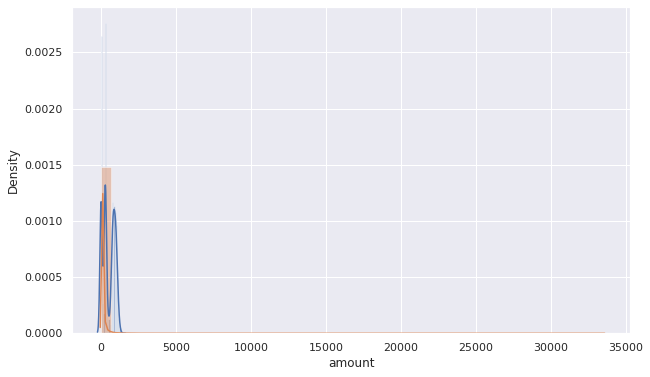

In [10]:
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot((card_transactions[card_transactions['is_fraud'] == True].amount))
sns.distplot((card_transactions[card_transactions['is_fraud'] != True].amount))
#sns.distplot(training_data[training_data['is_fraud'] == True].card_transactions_transaction_distance)
#sns.distplot(training_data[training_data['is_fraud'] != True].card_transactions_transaction_distance)

<AxesSubplot:xlabel='amount', ylabel='Density'>

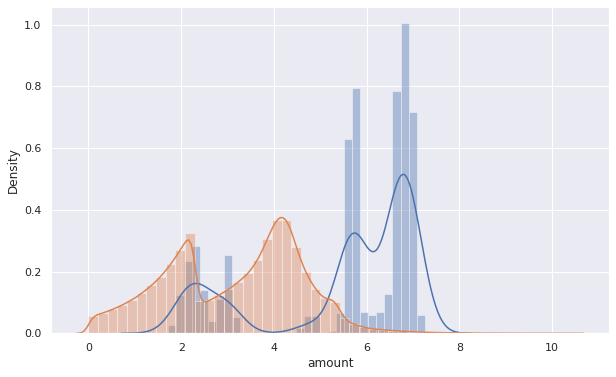

In [11]:
sns.set(rc={'figure.figsize':(10,6)})

sns.distplot(np.log(card_transactions[card_transactions['is_fraud'] == True].amount))
sns.distplot(np.log(card_transactions[card_transactions['is_fraud'] != True].amount))

### Transaction Category

<AxesSubplot:xlabel='category', ylabel='Count'>

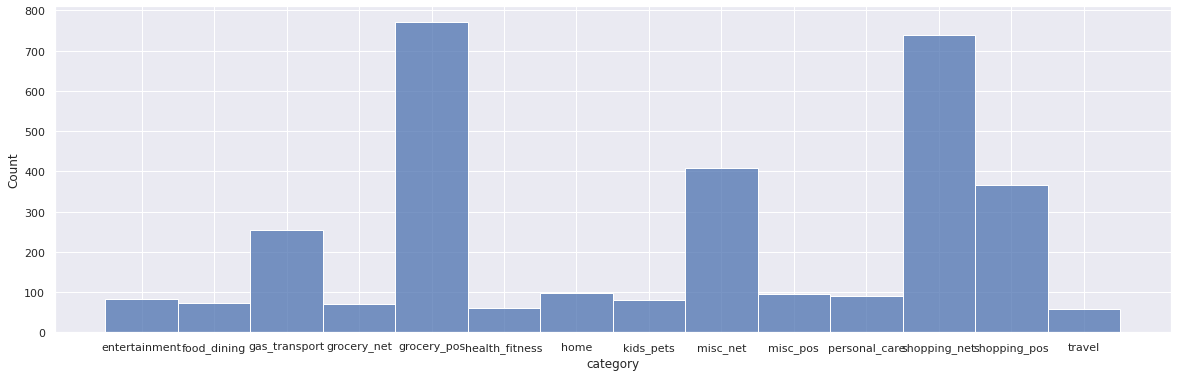

In [12]:
#Feature Exploration

sns.set(rc={'figure.figsize':(20,6)})
sns.histplot(card_transactions[card_transactions['is_fraud'] == True].category.sort_values())

#card_transactions[card_transactions['is_fraud'] == True].category.hist()
#card_transactions[card_transactions['is_fraud'] != True].category.hist()

<AxesSubplot:xlabel='category', ylabel='Count'>

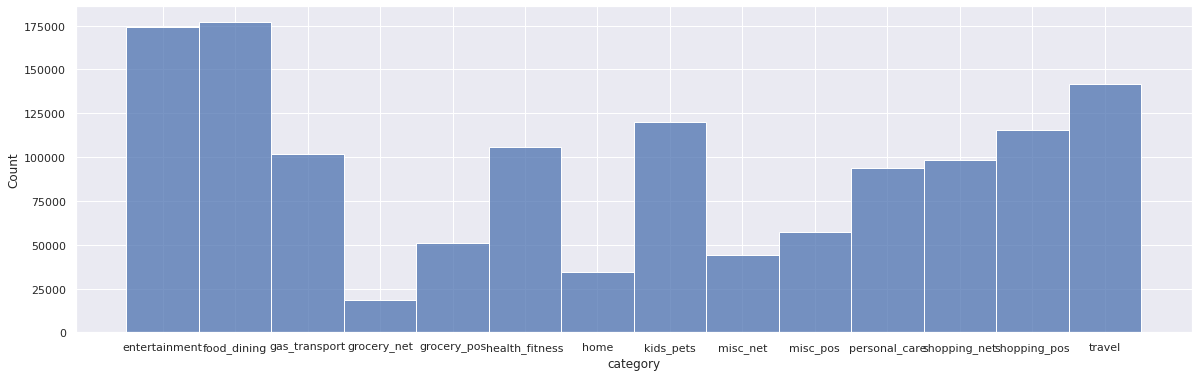

In [13]:
#card_transactions[card_transactions['is_fraud'] != True].category.hist()
sns.histplot(card_transactions[card_transactions['is_fraud'] != True].category.sort_values())

# Train a Model with Transaction Category (One-Hot Encoding)

In [14]:
###### Merge Tx merchant category and transform to One Hot Encoding

new_set = training_data.merge(card_transactions[['trans_id','category']], on='trans_id')
new_set = pd.get_dummies(new_set,prefix=['category'], columns = ['category'], drop_first=True)#.drop('card_transactions_transaction_distance',axis=1)
X = new_set.set_index('trans_id')
X.iloc[:,-16:]

,card_transactions_amount,card_transactions_transaction_distance,card_transactions_transaction_hour_of_day,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
trans_id,,,,,,,,,,,,,,,,
5df2e4e157360e161dec3d0efcc07113,280.52,91969.612014,0,0,0,0,1,0,0,0,0,0,0,0,0,0
56a4aa3f26687f98625fb811aa27c1c1,316.06,118693.486710,0,0,0,0,1,0,0,0,0,0,0,0,0,0
42b451600d91afd85d680581394a9de4,1006.36,41594.869210,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13cd837b85bb9f779c3265a72d4315e2,271.33,56662.386364,0,0,0,0,1,0,0,0,0,0,0,0,0,0
579b3a883b4030d91475428af9407c56,904.47,48332.349503,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78e696464be1791bc7f6f183d0e20c80,2.06,82900.812231,23,0,0,0,0,0,0,0,0,0,0,0,0,0
daa607f79119ff5d18fdc71ff7a71a98,77.87,80156.951029,23,0,1,0,0,0,0,0,0,0,0,0,0,0
3ff84bda701e1fded1ddc87374543570,66.02,46163.922620,23,0,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Try a model using new training set

from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,-16:], X.is_fraud, random_state = 0)

lr_clf = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)

y_test.astype(str).value_counts(), y_train.astype(str).value_counts()


(False    333547
 True        803
 Name: is_fraud, dtype: int64,
 False    1000607
 True        2442
 Name: is_fraud, dtype: int64)

Baseline Accuracy of Gradient Boosting classifier on training set: 0.998088827
Baseline Accuracy of Gradient Boosting classifier on test set: 0.998103783
Accuracy: 0.99810
Precision: 0.80287
Recall: 0.27895
F1: 0.41405
Confusion Matrix (Baseline Gradient Boosting Classifier)
 [[333492     55]
 [   579    224]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.80      0.28      0.41       803

    accuracy                           1.00    334350
   macro avg       0.90      0.64      0.71    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (Improved_model)')

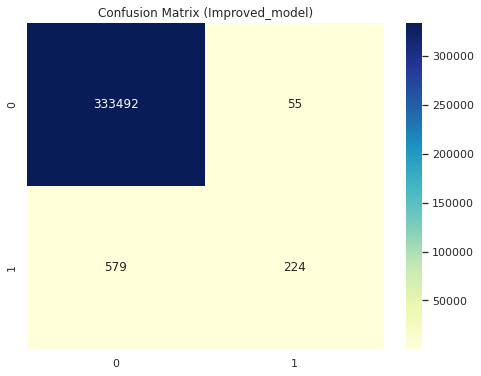

In [16]:
print('Baseline Accuracy of Gradient Boosting classifier on training set: {:.9f}'
     .format(lr_clf.score(X_train, y_train)))
print('Baseline Accuracy of Gradient Boosting classifier on test set: {:.9f}'
     .format(lr_clf.score(X_test, y_test)))

lr_predicted = lr_clf.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, lr_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, lr_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, lr_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, lr_predicted)))

print('Confusion Matrix (Baseline Gradient Boosting Classifier)\n', confusion)

print(classification_report(y_test, lr_predicted, target_names=['not Fraud', 'Fraud']))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap='YlGnBu', annot = True, fmt='d')
ax.set_title('Confusion Matrix (Improved_model)')

# Let's Try another Algorithm - XGBoost


<div>
<img src="https://github.com/yantkgcp/MLOps/blob/main/xgb_paper.png?raw=true" width="800"/>
</div>

### Sci-Kit Learn (including most non Deep Learning model) don't benefit from running on GPUs
### GPU would benefit training on datasets with high dimension or large sample using supported Library 

https://cloud.google.com/ai-platform/training/docs/using-gpus

In [18]:
!pip install xgboost --user

  Using cached xgboost-1.6.1-py3-none-manylinux2014_x86_64.whl (192.9 MB)


In [19]:
# Suppress all warnings
import xgboost as xgb

xg_clf = xgb.XGBClassifier(eval_metric="aucpr", #max_delta_step = 3,
                           max_depth=10,learning_rate=0.123,#scale_pos_weight=300,
                           use_label_encoder=False,
                           tree_method='gpu_hist',
                           random_state=0)
%time xg_clf.fit(X_train, y_train)

CPU times: user 3.86 s, sys: 1.46 s, total: 5.31 s
Wall time: 2.73 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.123, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Baseline Accuracy of XGboost classifier on training set: 0.999512486
Baseline Accuracy of XGboost classifier on test set: 0.999183490
Accuracy: 0.99918
Precision: 0.90520
Recall: 0.73724
F1: 0.81263
Confusion Matrix (XGboost Classifier)
 [[333485     62]
 [   211    592]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.91      0.74      0.81       803

    accuracy                           1.00    334350
   macro avg       0.95      0.87      0.91    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (XGBoost_model)')

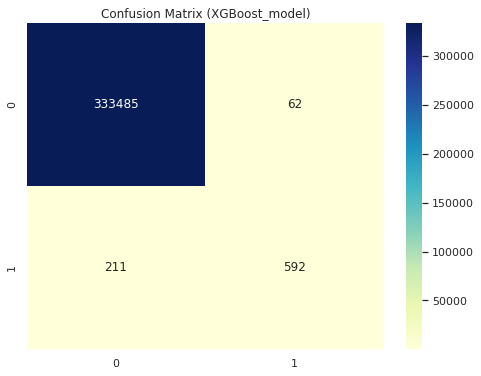

In [20]:
print('Baseline Accuracy of XGboost classifier on training set: {:.9f}'
     .format(xg_clf.score(X_train, y_train)))
print('Baseline Accuracy of XGboost classifier on test set: {:.9f}'
     .format(xg_clf.score(X_test, y_test)))

xg_predicted = xg_clf.predict(X_test)
confusion = confusion_matrix(y_test, xg_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, xg_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, xg_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, xg_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, xg_predicted)))

print('Confusion Matrix (XGboost Classifier)\n', confusion)

print(classification_report(y_test, xg_predicted, target_names=['not Fraud', 'Fraud']))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap='YlGnBu', annot = True, fmt='d')
ax.set_title('Confusion Matrix (XGBoost_model)')

<AxesSubplot:>

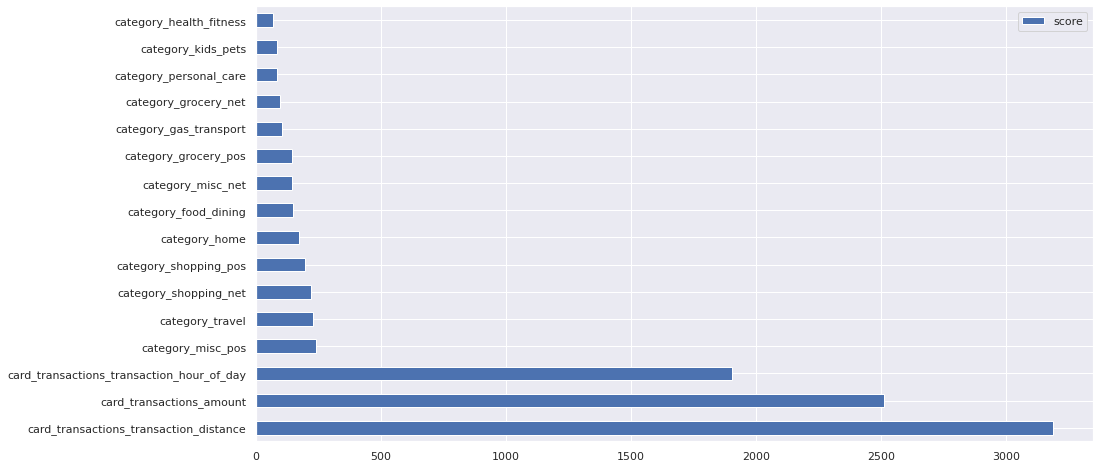

In [21]:
## Feature Importance

feature_important = xg_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

tmp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
tmp.nlargest(16, columns="score").plot(kind='barh', figsize = (15,8)) ## plot all 16 features

In [22]:
feature_important

{'card_transactions_amount': 2511.0,
 'card_transactions_transaction_distance': 3186.0,
 'card_transactions_transaction_hour_of_day': 1903.0,
 'category_food_dining': 148.0,
 'category_gas_transport': 105.0,
 'category_grocery_net': 97.0,
 'category_grocery_pos': 144.0,
 'category_health_fitness': 69.0,
 'category_home': 172.0,
 'category_kids_pets': 84.0,
 'category_misc_net': 145.0,
 'category_misc_pos': 242.0,
 'category_personal_care': 85.0,
 'category_shopping_net': 223.0,
 'category_shopping_pos': 197.0,
 'category_travel': 230.0}

# Try SMOTE - Oversampling 



<div>
<img src="https://github.com/yantkgcp/MLOps/blob/main/oversample.png?raw=true" width="700"/><img src="https://github.com/yantkgcp/MLOps/blob/main/smote.png?raw=true" width="600"/>
</div>
https://www.researchgate.net/publication/220543125_SMOTE_Synthetic_Minority_Over-sampling_Technique 


In [23]:
## Oversampling
#!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='minority', random_state=100)
X_res, y_res = ros.fit_resample(X_train, y_train)
y_res.value_counts()

False    1000607
True     1000607
Name: is_fraud, dtype: int64

In [24]:
#ros_clf = xgb.XGBClassifier(eval_metric="aucpr", max_depth=8,use_label_encoder=False).fit(X_res, y_res)
ros_clf = xgb.XGBClassifier(
    n_estimators=100,
    eval_metric="aucpr", 
    learning_rate=0.123,
    max_depth=10,
    use_label_encoder=False,
    tree_method='gpu_hist',
    random_state=0)

%time ros_clf.fit(X_res, y_res)

CPU times: user 3.62 s, sys: 1.73 s, total: 5.35 s
Wall time: 2.91 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.123, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [25]:

print('Oversampled Accuracy of XGboost classifier on oversampled training set: {:.9f}'
     .format(ros_clf.score(X_res, y_res)))
print('Oversampled Accuracy of XGboost classifier on test set: {:.9f}'
     .format(ros_clf.score(X_test, y_test)))

ros_predicted = ros_clf.predict(X_test)
confusion = confusion_matrix(y_test, ros_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, ros_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, ros_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, ros_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, ros_predicted)))

print('Confusion Matrix (XGboost Classifier)\n', confusion)

print(classification_report(y_test, ros_predicted, target_names=['not Fraud', 'Fraud']))

Oversampled Accuracy of XGboost classifier on oversampled training set: 0.998953635
Oversampled Accuracy of XGboost classifier on test set: 0.997559444
Accuracy: 0.99756
Precision: 0.49554
Recall: 0.89913
F1: 0.63894
Confusion Matrix (XGboost Classifier)
 [[332812    735]
 [    81    722]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.50      0.90      0.64       803

    accuracy                           1.00    334350
   macro avg       0.75      0.95      0.82    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (final_model)')

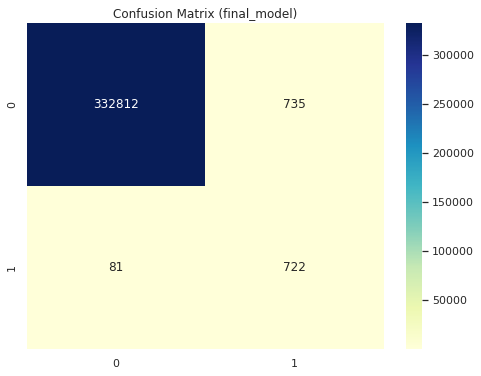

In [26]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')

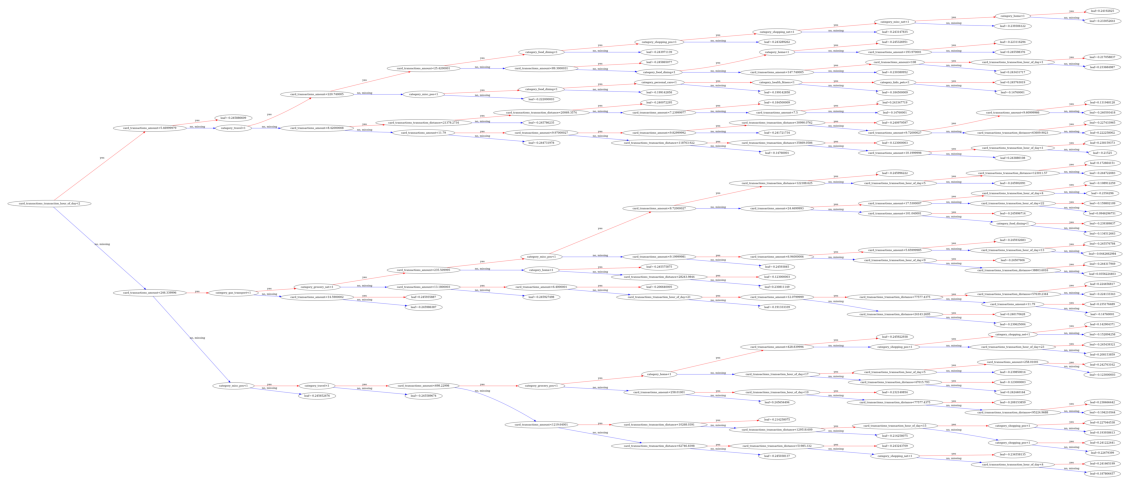

In [27]:

from xgboost import plot_tree

rcParams['figure.figsize'] = 20,15
#figure(figsize=(18, 16))
plot_tree(ros_clf,rankdir='LR')
#plt.show()
plt.savefig('xgb_tree.png')

## From 0 to 90%

<div>
<img src="https://github.com/yantkgcp/MLOps/blob/main/baseline_cfmx.png?raw=true" width="500"/><img src="https://github.com/yantkgcp/MLOps/blob/main/final_cfmx.png?raw=true" width="500"/>
</div>

# Let's Put It altogether on Google Cloud
